# Purpose
The goal is to train a GAN model that can generate digits. The primary purpose of this notebook is to gain more exposure to [keras_adversarial](https://github.com/bstriner/keras-adversarial#installation) package and what it has to offer.

In [1]:
%pylab inline

import os
import numpy as np
import pandas as pd
from scipy.misc import imread

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Reshape, InputLayer
from keras.regularizers import L1L2

from keras_adversarial import AdversarialModel, simple_gan, gan_targets
from keras_adversarial import AdversarialOptimizerSimultaneous, normal_latent_sampling

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
# set seed value, to reproduce results
seed = 42
rng = np.random.RandomState(seed)

In [3]:
# load data
train_path = 'Train/train.csv'
train = pd.read_csv(train_path)
print train.shape
train.head()

(49000, 2)


,filename,label
0,0.png,4
1,1.png,9
2,2.png,1
3,3.png,7
4,4.png,3


In [4]:
test_path = 'Train/test.csv'
test = pd.read_csv(test_path)
print test.shape
test.head()

(21000, 1)


,filename
0,49000.png
1,49001.png
2,49002.png
3,49003.png
4,49004.png


In [5]:
# load images
temp = []
for image in train.filename:
    image_path = os.path.join('Train', 'Images', 'train', image)
    img = imread(image_path, flatten=True)
    img = img.astype('float32')
    temp.append(img)

In [6]:
# images are 28 by 28 pixels
temp[1].shape

(28, 28)

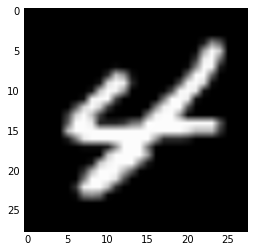

In [7]:
plt.imshow(temp[0], cmap='gray')
plt.show()

In [8]:
# looking at the matrix below, it looks like the 
# pixel range is between 0 and 255
print "Max:" + str(temp[1].max()), "Min:" + str(temp[1].min())
temp[1]

Max:255.0 Min:0.0


array([[   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.

In [14]:
train_x = np.stack(temp)
# normarlize:
train_x = train_x/255

# Model Architecture

In [33]:
input_dim = (28, 28) # for the discriminator
input_shape = 100 # for the generator
layer_1 = 500
layer_2 = 500
output_shape = 784 # 28x28
batch_size = 128

In [34]:
model_1 = Sequential([
    Dense(units=layer_1, input_dim=input_shape, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)),
    Dense(units=layer_2, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)),
    Dense(units=output_shape, activation='sigmoid', kernel_regularizer=L1L2(1e-5, 1e-5)),
    Reshape(input_dim),
])

# discriminator
model_2 = Sequential([
    InputLayer(input_shape=input_dim),
    Flatten(),
    Dense(units=layer_1, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)),
    Dense(units=layer_2, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)), 
    Dense(units=1, activation='sigmoid', kernel_regularizer=L1L2(1e-5, 1e-5)),
])

Here is the architecture of the two models

In [35]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 500)               50500     
_________________________________________________________________
dense_24 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_25 (Dense)             (None, 784)               392784    
_________________________________________________________________
reshape_4 (Reshape)          (None, 28, 28)            0         
Total params: 693,784
Trainable params: 693,784
Non-trainable params: 0
_________________________________________________________________


In [36]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 500)               392500    
_________________________________________________________________
dense_27 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 501       
Total params: 643,501
Trainable params: 643,501
Non-trainable params: 0
_________________________________________________________________


In [38]:
gan = simple_gan(model_1, model_2,
                 normal_latent_sampling((100,)))
model = AdversarialModel(base_model=gan,
                         player_params=[model_1.trainable_weights,
                                        model_2.trainable_weights])

model.adversarial_compile(adversarial_optimizer=AdversarialOptimizerSimultaneous(),
                          player_optimizers=['adam', 'adam'],
                          loss='binary_crossentropy')

history = model.fit(x=train_x,
                    y=gan_targets(train_x.shape[0]),
                    epochs=100,
                    batch_size=batch_size)

Epoch 1/100
49000/49000 [==============================] - 19s - loss: 18.5284 - player_0_loss: 17.1734 - player_0_yfake_loss: 6.7315 - player_0_yreal_loss: 9.1271 - player_1_loss: 1.3550 - player_1_yfake_loss: 0.0132 - player_1_yreal_loss: 0.0270    
Epoch 2/100
49000/49000 [==============================] - 16s - loss: 19.2791 - player_0_loss: 17.9695 - player_0_yfake_loss: 7.3167 - player_0_yreal_loss: 9.3763 - player_1_loss: 1.3096 - player_1_yfake_loss: 0.0150 - player_1_yreal_loss: 0.0181    
Epoch 3/100
49000/49000 [==============================] - 16s - loss: 18.3574 - player_0_loss: 17.2305 - player_0_yfake_loss: 7.5618 - player_0_yreal_loss: 8.5495 - player_1_loss: 1.1270 - player_1_yfake_loss: 0.0033 - player_1_yreal_loss: 0.0045    
Epoch 4/100
49000/49000 [==============================] - 17s - loss: 19.5641 - player_0_loss: 18.4453 - player_0_yfake_loss: 8.1589 - player_0_yreal_loss: 9.1748 - player_1_loss: 1.1188 - player_1_yfake_loss: 0.0034 - player_1_yreal_loss: 0.0

In [39]:
gan.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 28, 28)        0                                            
____________________________________________________________________________________________________
lambda_4 (Lambda)                (None, 100)           0                                            
____________________________________________________________________________________________________
gan (Model)                      [(None, 1), (None, 1) 1337285                                      
____________________________________________________________________________________________________
yfake (Activation)               (None, 1)             0                                            
___________________________________________________________________________________________

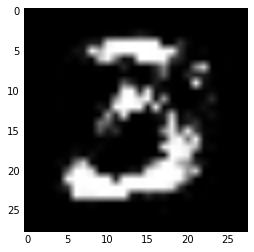

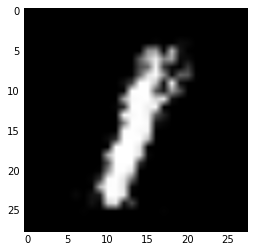

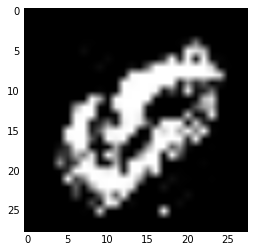

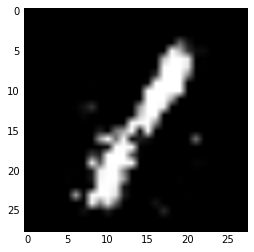

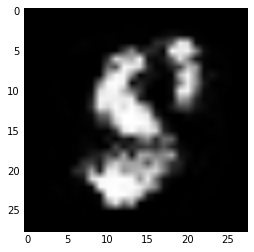

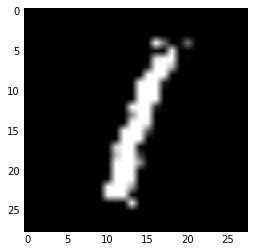

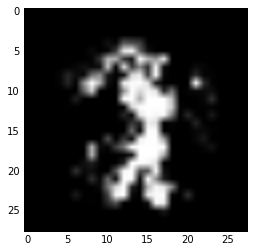

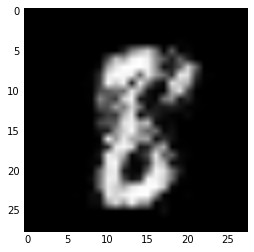

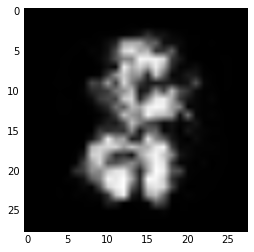

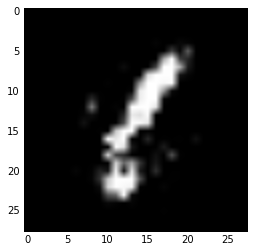

In [40]:
zsamples = np.random.normal(size=(10, 100))
pred = model_1.predict(zsamples)
for i in range(pred.shape[0]):
    plt.imshow(pred[i, :], cmap='gray')
    plt.show()